# CUDA performace against number of threads per block

In [1]:
CODE_ROOT = pwd() * "/"

include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean_CUDA.jl")
include(CODE_ROOT * "visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [4]:
using Dates

In [5]:
using DelimitedFiles

In [2]:
using BenchmarkTools

import CUDA

In [3]:
CUDA.CuDevice(0)

CuDevice(0): NVIDIA GeForce GTX 1080

In [4]:
function calculate_normal_velocity_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, threads) threads=threads maxregs=maxregs calculate_normal_velocity_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityTendency,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.cellsOnEdge,
                                                                        mpasOcean.nEdgesOnEdge,
                                                                        mpasOcean.edgesOnEdge,
                                                                        mpasOcean.weightsOnEdge,
                                                                        mpasOcean.fEdge,
                                                                        mpasOcean.dcEdge,
                                                                        mpasOcean.gravity)
end


calculate_normal_velocity_tendency_cuda_threadcount! (generic function with 1 method)

In [5]:
function update_normal_velocity_by_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nEdges, threads) threads=threads maxregs=maxregs update_normal_velocity_by_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.dt,
                                                                        mpasOcean.normalVelocityTendency)
end


update_normal_velocity_by_tendency_cuda_threadcount! (generic function with 1 method)

In [6]:
function calculate_ssh_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nCells, threads) threads=threads maxregs=maxregs calculate_ssh_tendency_cuda_kernel!(
                                                                        mpasOcean.nCells,
                                                                        mpasOcean.sshTendency,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.bottomDepth,
                                                                        mpasOcean.nEdgesOnCell,
                                                                        mpasOcean.edgesOnCell,
                                                                        mpasOcean.cellsOnCell,
                                                                        mpasOcean.areaCell,
                                                                        mpasOcean.edgeSignOnCell,
                                                                        mpasOcean.dvEdge)
end


calculate_ssh_tendency_cuda_threadcount! (generic function with 1 method)

In [7]:
function update_ssh_by_tendency_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA; threads=1024, maxregs=64)
    CUDA.@cuda blocks=cld(mpasOcean.nCells, threads) threads=threads maxregs=maxregs update_ssh_by_tendency_cuda_kernel!(
                                                                        mpasOcean.nCells,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.dt,
                                                                        mpasOcean.sshTendency)
end


update_ssh_by_tendency_cuda_threadcount! (generic function with 1 method)

In [8]:
function forward_backward_step_cuda_threadcount!(mpasOcean::MPAS_Ocean_CUDA;
                                                 threadsCN=1024, threadsUN=1024, threadsCS=1024, threadsUS=1024,
                                                 maxregsCN=64, maxregsUN=64, maxregsCS=64, maxregsUS=64)
    calculate_normal_velocity_tendency_cuda_threadcount!(mpasOcean; threads=threadsCN, maxregs=maxregsCN)

    update_normal_velocity_by_tendency_cuda_threadcount!(mpasOcean; threads=threadsUN, maxregs=maxregsUN)

    calculate_ssh_tendency_cuda_threadcount!(mpasOcean; threads=threadsCS, maxregs=maxregsCS)

    update_ssh_by_tendency_cuda_threadcount!(mpasOcean; threads=threadsUS, maxregs=maxregsUS)
end

forward_backward_step_cuda_threadcount! (generic function with 1 method)

# Test mesh

In [9]:
mpasOcean = MPAS_Ocean(CODE_ROOT * "./MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                    "base_mesh.nc",
                    "mesh.nc")
typeof(mpasOcean)

MPAS_Ocean

# Define Initial Condition

In [10]:
include("mode_init/exactsolutions.jl")

DetermineInertiaGravityWaveExactSurfaceElevation (generic function with 1 method)

In [11]:
nx, ny, etaHat = 1, 2, 1e-3
etaHat, f0, kX, kY, omega = inertiaGravityWaveParams(mpasOcean, nx, ny, etaHat)
inertiaGravityExactSolution!(mpasOcean, etaHat, f0, kX, kY, omega, 0.0) # could also do gaussianInit!

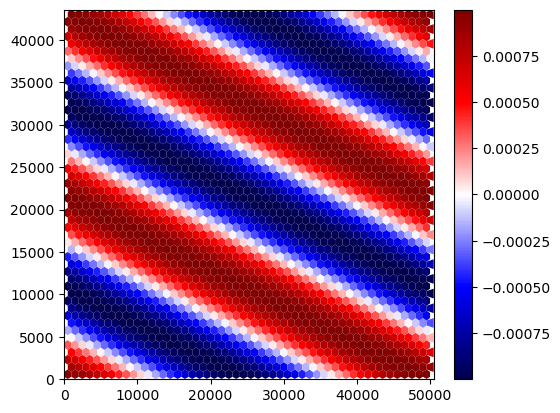

In [12]:
fig, ax, cbar, col = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Compare benchmarks with different threads per block
Initially, only threads per block of ssh calculation and update changes

In [13]:
function threadcount_test(; mpasOcean=mpasOcean, minblocksize=64, maxblocksize=1024, cases=8, periodicity="Periodic")
    threadcounts = []
    ttimes = []

    for blocksize::Integer in Int.(round.(range(minblocksize, maxblocksize, length=cases)))
        
        println("Now benchmarking with $blocksize threads per block.")
        
        bench = @benchmark forward_backward_step_cuda_threadcount!($mpasOcean; threadsCS=$blocksize, threadsUS=$blocksize) seconds=5
        
        append!(threadcounts, [blocksize])
    
        append!(ttimes, [bench.times])

    end

    means = []
    for times in ttimes
        append!(means, mean(times))
    end

    stdevs = []
    for i in 1:length(ttimes)
        append!(stdevs, sqrt(mean( (ttimes[i] .- means[i]).^2 )) )
    end
    
    return threadcounts, ttimes, means, stdevs
end

threadcount_test (generic function with 1 method)

In [14]:
println()
mpasOcean = MPAS_Ocean_CUDA(mpasOcean)

MPAS_Ocean_CUDA([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0009735789028731604, 0.0009372819894918916, 0.0008862035792312148, 0.000821149209133704, 0.0007431448254773944, 0.0006534206039901055, 0.0005533915492433441, 0.0004446351791849277, 0.0003288666467385833, 0.00020791169081775946  …  0.0003485720473218121, 0.00046329603511986137, 0.0005707135676844307, 0.0006691306063588568, 0.0007569950556517548, 0.0008329212407100997, 0.0008957117602394126, 0.0009443763702374807, 0.0009781476007338053, 0.000996492859249504], [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0  …  1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], [866025.4037844387, 866025.4037844387, 866025.4037844387, 866025.4037844387, 866025.4037844386, 866025.4037844387, 866025.4037844387, 866025.4037844387, 866025.4037844387, 866025.4037844387  …  866025.4037844392, 866025.4037844392, 866025.4037844392

In [15]:
threadcountsS, ttimesS, meansS, stdevsS = threadcount_test(mpasOcean=mpasOcean,
                                                            minblocksize=16, maxblocksize=1024, cases=64)

Now benchmarking with 16 threads per block.
Now benchmarking with 32 threads per block.
Now benchmarking with 48 threads per block.
Now benchmarking with 64 threads per block.
Now benchmarking with 80 threads per block.
Now benchmarking with 96 threads per block.
Now benchmarking with 112 threads per block.
Now benchmarking with 128 threads per block.
Now benchmarking with 144 threads per block.
Now benchmarking with 160 threads per block.
Now benchmarking with 176 threads per block.
Now benchmarking with 192 threads per block.
Now benchmarking with 208 threads per block.
Now benchmarking with 224 threads per block.
Now benchmarking with 240 threads per block.
Now benchmarking with 256 threads per block.
Now benchmarking with 272 threads per block.
Now benchmarking with 288 threads per block.
Now benchmarking with 304 threads per block.
Now benchmarking with 320 threads per block.
Now benchmarking with 336 threads per block.
Now benchmarking with 352 threads per block.
Now benchmarking

(Any[16, 32, 48, 64, 80, 96, 112, 128, 144, 160  …  880, 896, 912, 928, 944, 960, 976, 992, 1008, 1024], Any[[53050.0, 16351.0, 14043.0, 12084.0, 11941.0, 11510.0, 11909.0, 11186.0, 11441.0, 10947.0  …  33291.0, 33195.0, 32917.0, 33666.0, 36749.0, 32195.0, 32304.0, 32677.0, 32787.0, 33373.0], [49589.0, 15859.0, 13845.0, 11927.0, 11733.0, 11385.0, 11480.0, 11022.0, 11629.0, 11158.0  …  32954.0, 32936.0, 33158.0, 32811.0, 33217.0, 33361.0, 33021.0, 33284.0, 33134.0, 33896.0], [47120.0, 17208.0, 14973.0, 13348.0, 14072.0, 13122.0, 13175.0, 13247.0, 13275.0, 12931.0  …  33453.0, 33158.0, 32688.0, 34230.0, 32916.0, 33575.0, 33353.0, 33961.0, 33227.0, 33614.0], [49126.0, 15800.0, 13400.0, 11899.0, 11745.0, 11109.0, 11456.0, 10937.0, 11487.0, 10990.0  …  32629.0, 33656.0, 33002.0, 32337.0, 32568.0, 32414.0, 33157.0, 32845.0, 32967.0, 32954.0], [47286.0, 15381.0, 13141.0, 11823.0, 11708.0, 12028.0, 11470.0, 11183.0, 11365.0, 11554.0  …  33063.0, 33422.0, 33165.0, 33973.0, 33721.0, 33487.0, 331

In [20]:
savedata = true
if savedata
    fpath = CODE_ROOT * "output/cuda_occupancy/"
    mkpath(fpath)
    fname = "$fpath$(Dates.now()).txt"
    open(fname, "w") do io
        writedlm(io, [threadcountsS, ttimesS, meansS, stdevsS])
    end
    println("saved to $fname")
end

saved to /home/rrs/Desktop/MPAS/MPAS_Ocean_Julia/output/cuda_occupancy/2022-12-14T16:56:46.807.txt


In [7]:
function latestfile(dir, filterfunc)
    return filter(filterfunc, readdir(dir, join=true))[end]
end

latestfile (generic function with 1 method)

In [35]:
usesaved = true
if usesaved
    fpath = CODE_ROOT * "output/cuda_occupancy/"
    fname = latestfile(fpath, x->x[end-3:end] == ".txt")
    data = readdlm(fname)
    threadcountsS = data[1,1:64]
    ttimesS =       reshape(data[2,:], (64,10000))
    meansS =        data[3,1:64]
    stdevsS =       data[4,1:64]
end

64-element Vector{Any}:
 46305.49480280916
 47220.53953652013
 46584.479714356785
 46624.558747530435
 46625.9043699038
 46723.906568486775
 46805.381011198035
 46893.350799604166
 46828.91133946886
 46928.2265407235
 46950.77651881264
 47076.32636750085
 47150.26617090447
     ⋮
 49729.928750373416
 49659.96737716798
 49799.08924222765
 50246.71297134815
  6421.474607242308
 50163.28844226649
 49888.39290962601
 50362.51401195198
 49915.05073932262
 50767.74670592609
 50241.241628910946
  6644.718263312983

## Plot benchmarks against resolution

In [ ]:
means = []
for times in ttimes
    append!(means, mean(times))
end

stdevs = []
for i in 1:length(ttimes)
    append!(stdevs, sqrt(mean( (ttimes[i] .- means[i]).^2 )) )
end

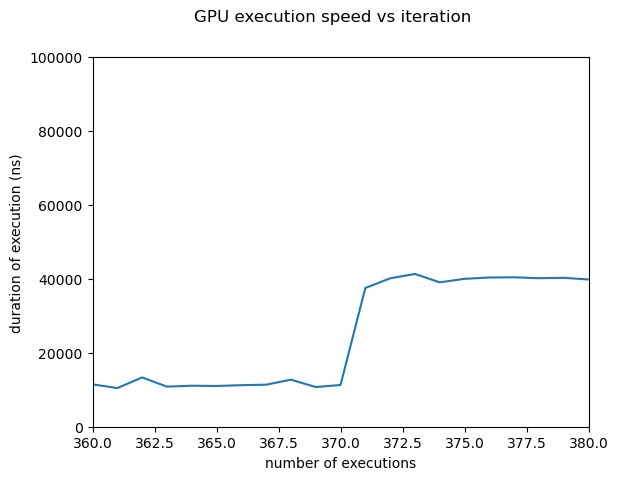

PyObject Text(0.5, 24.0, 'number of executions')

In [79]:
plt.plot(ttimesS[63])
plt.ylim(0, 100000)
plt.xlim(360, 380)
plt.suptitle("GPU execution speed vs iteration")
plt.ylabel("duration of execution (ns)")
plt.xlabel("number of executions")

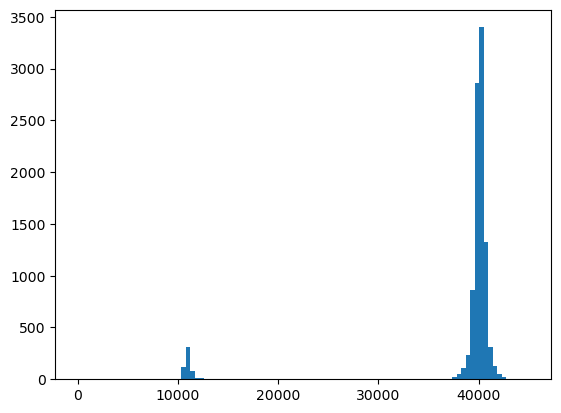

(5.018701e6, 39063.2559)

In [72]:
hist(ttimesS[63], bins=100, range=[0,45000])
maximum(ttimesS[63]), meansS[63]

In [48]:
times = mapreduce(permutedims, vcat, ttimesS)

64×10000 Matrix{Float64}:
 53050.0  16351.0  14043.0  12084.0  …  32304.0  32677.0  32787.0  33373.0
 49589.0  15859.0  13845.0  11927.0     33021.0  33284.0  33134.0  33896.0
 47120.0  17208.0  14973.0  13348.0     33353.0  33961.0  33227.0  33614.0
 49126.0  15800.0  13400.0  11899.0     33157.0  32845.0  32967.0  32954.0
 47286.0  15381.0  13141.0  11823.0     33196.0  33475.0  33702.0  33657.0
 44837.0  16172.0  13170.0  11974.0  …  33627.0  33709.0  33644.0  33522.0
 48351.0  15792.0  13235.0  11813.0     33329.0  33937.0  33756.0  33240.0
 47047.0  15937.0  12979.0  11557.0     32807.0  33044.0  32925.0  33038.0
 47183.0  16008.0  13564.0  11921.0     33115.0  32833.0  33799.0  33564.0
 48571.0  16526.0  13633.0  12184.0     33423.0  33565.0  33805.0  33221.0
 48219.0  16473.0  14933.0  12622.0  …  33704.0  33239.0  34817.0  34254.0
 49533.0  15923.0  13978.0  11829.0     32661.0  33926.0  33246.0  33304.0
 48932.0  15775.0  13714.0  11924.0     33633.0  33818.0  33796.0  33688.0

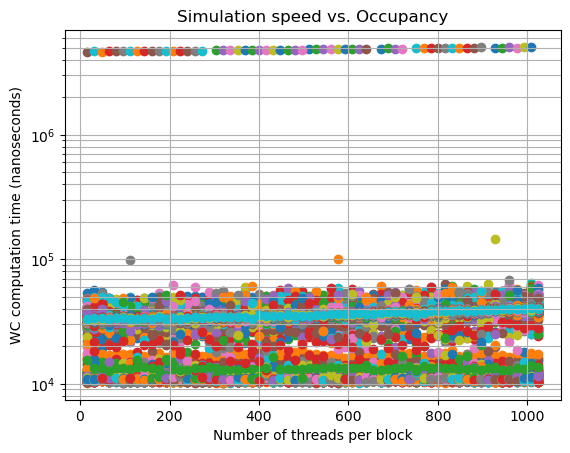

PyObject Text(0.5, 1.0, 'Simulation speed vs. Occupancy')

In [59]:
fig, ax = subplots(1,1)

# ax.set_xscale("log")
ax.set_yscale("log")

for i in 1:size(times)[2]
#     println(size(threadcountsS, size()))
    scatter(threadcountsS, times[:,i])
end
# plot(threadcountsS, meansS, marker="s") # yerr=stdevsC
# errorbar(threadcountsS, meansS, yerr=stdevsS, linestyle="None")

ylabel("WC computation time (nanoseconds)")
xlabel("Number of threads per block")

# legend()

grid(which="both")

title("Simulation speed vs. Occupancy")

In [94]:
lowmeans = zeros(size(meansS))
for i in 1:size(times)[1]
    lowmeans[i] = mean(times[i,:300])
end

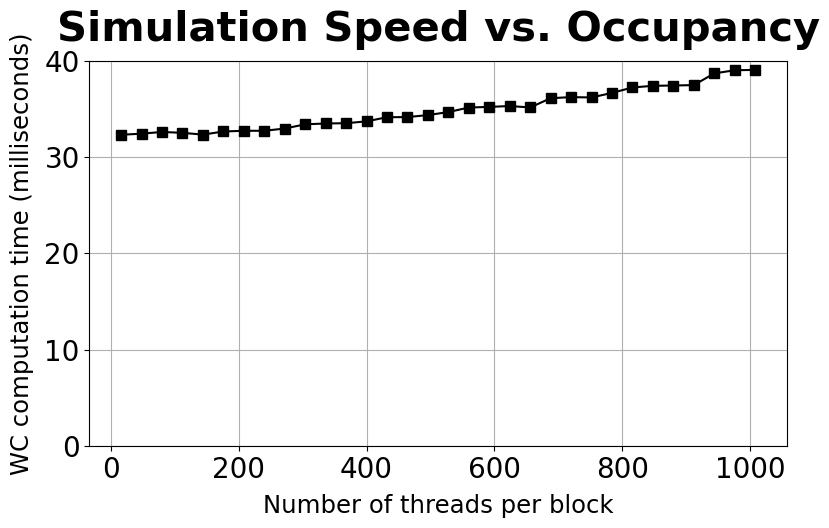

PyObject Text(0.5, 1.03, 'Simulation Speed vs. Occupancy')

In [36]:
fig, ax = subplots(1,1, figsize=(9,5))

# ax.set_xscale("log")
# ax.set_yscale("log")

plot(threadcountsS[1:2:end], meansS[1:2:end]/1000, marker="s", markersize=7.5, color="black") # yerr=stdevsC
# errorbar(threadcountsS, meansS, yerr=stdevsS, linestyle="None")

plt.ylim(0, 40)

ylabel("WC computation time (milliseconds)", fontsize=17.5, labelpad=7.5)
xlabel("Number of threads per block", fontsize=17.5, labelpad=7.5)
ax.tick_params(axis="both", which="major", labelsize=20)

# legend()

grid(which="both")

title("Simulation Speed vs. Occupancy", fontweight="bold", fontsize=30, y=1.03)

In [37]:
saveplot = true
if saveplot
    fig.savefig(CODE_ROOT * "output/cuda_occupancy/speed_occupancy_plot.pdf", bbox_inches="tight")
    println("saved")
end

saved


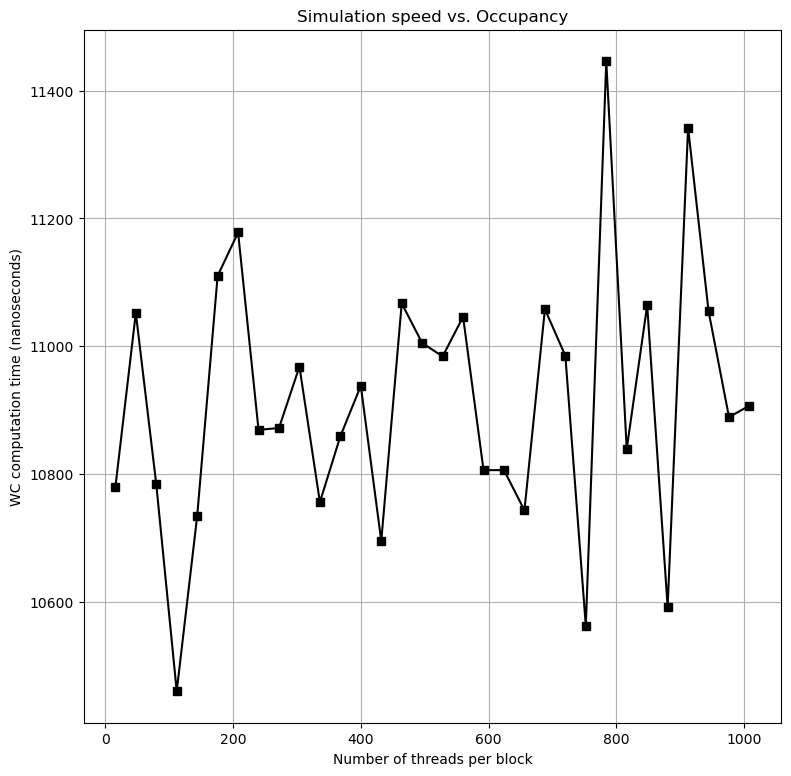

PyObject Text(0.5, 1.0, 'Simulation speed vs. Occupancy')

In [95]:
fig, ax = subplots(1,1, figsize=(9,9))

# ax.set_xscale("log")
# ax.set_yscale("log")

plot(threadcountsS[1:2:end], lowmeans[1:2:end], marker="s", color="black") # yerr=stdevsC
# errorbar(threadcountsS, meansS, yerr=stdevsS, linestyle="None")

ylabel("WC computation time (nanoseconds)")
xlabel("Number of threads per block")

# legend()

grid(which="both")

title("Simulation speed vs. Occupancy")

In [18]:
kernelnorm = CUDA.@cuda launch=false calculate_normal_velocity_tendency_cuda_kernel!(
                                                                        mpasOcean.nEdges,
                                                                        mpasOcean.normalVelocityTendency,
                                                                        mpasOcean.normalVelocityCurrent,
                                                                        mpasOcean.sshCurrent,
                                                                        mpasOcean.cellsOnEdge,
                                                                        mpasOcean.nEdgesOnEdge,
                                                                        mpasOcean.edgesOnEdge,
                                                                        mpasOcean.weightsOnEdge,
                                                                        mpasOcean.fEdge,
                                                                        mpasOcean.dcEdge,
                                                                        mpasOcean.gravity)

CUDA.HostKernel{typeof(calculate_normal_velocity_tendency_cuda_kernel!), Tuple{Int64, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceMatrix{Int32, 1}, CUDA.CuDeviceVector{Int32, 1}, CUDA.CuDeviceMatrix{Int32, 1}, CUDA.CuDeviceMatrix{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, CUDA.CuDeviceVector{Float64, 1}, Float64}}(calculate_normal_velocity_tendency_cuda_kernel!, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8), CUDA.CuModule(Ptr{Nothing} @0x00000000083161a0, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8)), CUDA.CuFunction(Ptr{Nothing} @0x0000000008417af0, CUDA.CuModule(Ptr{Nothing} @0x00000000083161a0, CuContext(0x00000000057cbda0, instance 558b5aa46fd4a7d8))))

In [19]:
CUDA.launch_configuration(kernelnorm.fun)

(blocks = 20, threads = 1024)

In [20]:
CUDA.maxthreads(kernelnorm)

1024

In [21]:
threadcounts = collect(1:1:1024)

occupancies = collect([CUDA.occupancy(kernelnorm.fun, t) for t in threadcounts])

1024-element Vector{Float64}:
 0.015625
 0.03125
 0.046875
 0.0625
 0.078125
 0.09375
 0.109375
 0.125
 0.140625
 0.15625
 0.171875
 0.1875
 0.203125
 ⋮
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.484375
 0.5

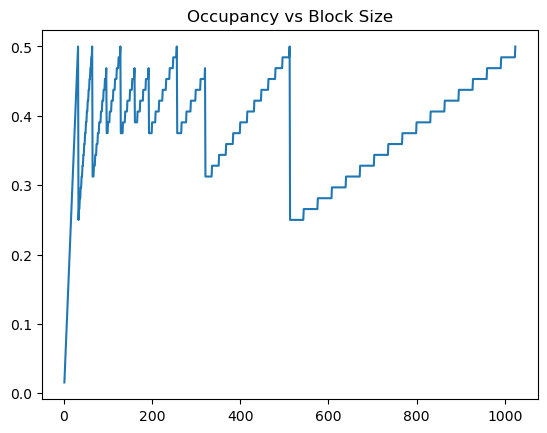

PyObject Text(0.5, 1.0, 'Occupancy vs Block Size')

In [24]:
plot(threadcounts, occupancies)

title("Occupancy vs Block Size")

In [21]:
CUDA.occupancy(kernelnorm.fun, 1)

0.015625

In [11]:
cld(mpasOcean.nEdges, 1024)

8

In [12]:
mpasOcean.nEdges/20

375.0